# Creating Environment

In [22]:
from PPO_Environment import Environment

# PPO Implementation

### Creating the Actor, Critic Networks

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from PPO_Network import PolicyNetwork, ValueNetwork

### Action Sampling and Log Probability

In [24]:
import numpy as np

In [25]:
def select_action(policy_net, state):
    mean, std = policy_net(state)
    std = std.clamp(min=1e-5, max=1.0)

    # Defensive checks
    if torch.isnan(mean).any() or torch.isinf(mean).any():
        print("Mean contained NaN or Inf; replacing with zeros")
        mean = torch.zeros_like(mean)

    if torch.isnan(std).any() or torch.isinf(std).any():
        print("Std contained NaN or Inf; replacing with 0.1")
        std = torch.ones_like(std) * 0.1

    dist = torch.distributions.Normal(mean, std)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum(dim=-1)
    entropy = dist.entropy().sum(dim=-1)

    if torch.isnan(action).any() or torch.isinf(action).any():
        print("Action contained NaN or Inf; replacing with mean")
        action = mean

    return action, log_prob, entropy


### Collecting RollOut / Experience / Trajectories

In [26]:
def collect_trajectories(envs, policy_net, value_net, horizon, device):
    state,_ = envs.reset()

    states, actions, rewards, dones, log_probs, values = [], [], [], [], [], []

    termination_reasons=[]

    for _ in range(horizon):
        state_tensor = torch.FloatTensor(state).to(device)  # shape (n_envs, obs_dim)

        action, log_prob, _ = select_action(policy_net, state_tensor)
        value = value_net(state_tensor).squeeze(-1) # shape (n_envs,)

        safe_action = action.detach().cpu().numpy() # (n_envs, action_dim)
        safe_action = np.clip(safe_action, envs.single_action_space.low, envs.single_action_space.high)

        next_state, reward, terminated,truncated, infos = envs.step(safe_action)

        done=np.logical_or(terminated, truncated).astype(float)

        # Log termination reasons for all envs
        for i, term in enumerate(terminated):
            if term:
                if "final_info" in infos and infos["final_info"][i] is not None:
                    termination_reasons.append(infos["final_info"][i].get("reason", "unknown"))
                else:
                    termination_reasons.append("unknown")

            
        states.append(torch.FloatTensor(state)) # shape (n_envs, obs_dim)
        actions.append(action)                  # shape (n_envs, action_dim)
        rewards.append(torch.tensor(reward, dtype=torch.float32)) # shape (n_envs,)
        dones.append(torch.tensor(done, dtype=torch.float32))     # shape (n_envs,)
        log_probs.append(log_prob.detach())   # shape (n_envs,)               
        values.append(value.detach())         # shape (n_envs,)

        state = next_state  


    return {
            'states': torch.stack(states).to(device),         # shape: (horizon, n_envs, obs_dim)
            'actions': torch.stack(actions).to(device),                       # shape: (horizon, n_envs, action_dim)
            'rewards': torch.stack(rewards).to(device),                       # shape: (horizon, n_envs)
            'dones': torch.stack(dones).to(device),                           # shape: (horizon, n_envs)
            'log_probs': torch.stack(log_probs).to(device),                   # shape: (horizon, n_envs)
            'values': torch.stack(values).to(device),                         # shape: (horizon, n_envs)
            'next_state': torch.FloatTensor(state).to(device),                 # shape: (n_envs, obs_dim)
            'termination_reasons': termination_reasons
            }

### Compute General Advantage Estimate (GAE)

In [27]:
def compute_gae(rewards, values, dones, next_value, gamma=0.99, lam=0.95):
    H, N = rewards.shape
    advantages = torch.zeros_like(rewards, device=rewards.device)
    last_adv = torch.zeros(N, device=rewards.device)

    for t in reversed(range(H)):
        if t == H - 1:
            next_non_terminal = 1.0 - dones[-1]
            next_values = next_value
        else:
            next_non_terminal = 1.0 - dones[t + 1]
            next_values = values[t + 1]

        delta = rewards[t] + gamma * next_values * next_non_terminal - values[t]
        advantages[t] = last_adv = delta + gamma * lam * next_non_terminal * last_adv

    returns = advantages + values
    return advantages, returns


### PPO Update

In [28]:
def PPO_update(policy_net,value_net,policy_optimizer,value_optimizer,states,actions,old_log_probs,returns,advantages,ppo_epochs,eps_clip,entropy_coef):

    # Flatten the batches: (H, N, *) -> (H*N, *)
    H, N = states.shape[:2]
    states = states.reshape(H * N, -1)
    actions = actions.reshape(H * N, -1)
    old_log_probs = old_log_probs.reshape(H * N)
    returns = returns.reshape(H * N)
    advantages = advantages.reshape(H * N)

    
    #Normalizing Advantages for training stability
    advantages=(advantages-advantages.mean())/(advantages.std()+1e-8)

    policy_net.train()
    value_net.train()

    for _ in range(ppo_epochs):

        #Forward pass through policy network
        mean,std=policy_net(states)
        std = std.clamp(min=1e-5, max=1.0)

        dist=torch.distributions.Normal(mean,std)
        new_log_probs=dist.log_prob(actions).sum(axis=-1)
        entropy=dist.entropy().sum(axis=-1)

        #Ratio of new policy and old policy
        ratio=torch.exp(new_log_probs-old_log_probs) #same as π_new(a|s) / π_old(a|s)

        #Surrogate Loss Function
        surr1=ratio*advantages
        surr2=torch.clamp(ratio,1-eps_clip,1+eps_clip)*advantages
        policy_loss=-torch.min(surr1,surr2).mean()-entropy_coef*entropy.mean()

        #Update policy network
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        #Value Loss
        predicted_values=value_net(states).squeeze(-1)
        value_loss=F.mse_loss(predicted_values,returns)

        #Update value network
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

# Training Loop

In [29]:
from gymnasium.vector import SyncVectorEnv
from collections import Counter, defaultdict

# --- Hyperparams ---
num_versions = 5   # Number of different reward versions
num_envs = 8       # Per version
learning_rate = 5e-5
horizon = 2000
ppo_epochs = 10
total_iterations = 500
eps_clip = 0.05

# --- Make multiple envs ---
def make_env(reward_version):
    def _init():
        return Environment(reward_version=reward_version)
    return _init

version = 4
env = SyncVectorEnv([make_env(version) for _ in range(num_envs)])

state_dim = env.single_observation_space.shape[0]
action_dim = env.single_action_space.shape[0]

In [30]:
# --- Multiple networks & optimizers ---

# policy_nets = [PolicyNetwork(state_dim, action_dim).to(device) for _ in range(num_versions)]
# value_nets = [ValueNetwork(state_dim).to(device) for _ in range(num_versions)]

# policy_optimizers = [torch.optim.Adam(policy_nets[i].parameters(), lr=learning_rate) for i in range(num_versions)]
# value_optimizers = [torch.optim.Adam(value_nets[i].parameters(), lr=learning_rate) for i in range(num_versions)]


policy_net = PolicyNetwork(state_dim, action_dim).to(device)
value_net = ValueNetwork(state_dim).to(device)

policy_net.load_state_dict(torch.load(f"PPO_saved_models/policy_net_v{version}_v4.pt"))
value_net.load_state_dict(torch.load(f"PPO_saved_models/value_net_v{version}_v4.pt"))

policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
value_optimizer = torch.optim.Adam(value_net.parameters(), lr=learning_rate)


# --- Logging ---
# reward_logs = {v: [] for v in range(1, num_versions + 1)}
# reason_logs = {v: [] for v in range(1, num_versions + 1)}
# center_offsets = {v: [] for v in range(1, num_versions + 1)}
# avg_velocities = {v: [] for v in range(1, num_versions + 1)}
# reward_components_logs = {v: defaultdict(list) for v in range(1, num_versions + 1)}
# y_reached_logs = {v: [] for v in range(1, num_versions + 1)}

reward_logs = {4: []}
reason_logs = {4: []}
center_offsets = {4: []}
avg_velocities = {4: []}
reward_components_logs = {4: defaultdict(list)}
y_reached_logs = {4: []}


# --- Reward component helper ---
def log_reward_components(states, storage):
    r_off_center = -0.2 * np.abs(states[:, :, 4].cpu().numpy())
    r_center_bonus = (np.abs(states[:, :, 4].cpu().numpy()) < 1.0).astype(float) * 0.5
    r_velocity = np.where(states[:, :, 2].cpu().numpy() > 1.0,
                          0.1 * states[:, :, 2].cpu().numpy(),
                          np.where(states[:, :, 2].cpu().numpy() > 0,
                                   0.005 * states[:, :, 2].cpu().numpy(), -0.3))
    r_heading = -0.1 * np.abs(states[:, :, 3].cpu().numpy() - np.pi / 2)

    storage["off_center"].append(r_off_center.mean())
    storage["center_bonus"].append(r_center_bonus.mean())
    storage["velocity"].append(r_velocity.mean())
    storage["velocity_raw"].append(states[:, :, 2].cpu().numpy().mean())
    storage["heading"].append(r_heading.mean())


DeferredCudaCallError: CUDA call failed lazily at initialization with error: module 'torch' has no attribute 'version'

CUDA call was originally invoked at:

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Python\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Python\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Python\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Python\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 645, in run_forever
    self._run_once()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1999, in _run_once
    handle._run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Python\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "c:\Python\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "c:\Python\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
    await result
  File "c:\Python\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "c:\Python\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "c:\Python\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "c:\Python\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "c:\Python\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell
    result = self._run_cell(
  File "c:\Python\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell
    result = runner(coro)
  File "c:\Python\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "c:\Python\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "c:\Python\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "c:\Python\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30700\972161611.py", line 1, in <module>
    import torch
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "c:\Python\.venv\Lib\site-packages\torch\__init__.py", line 2064, in <module>
    _C._initExtension(_manager_path())
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "c:\Python\.venv\Lib\site-packages\torch\cuda\__init__.py", line 317, in <module>
    _lazy_call(_check_capability)
  File "c:\Python\.venv\Lib\site-packages\torch\cuda\__init__.py", line 314, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


In [32]:
import sys
print(sys.executable)


c:\Python\.venv\Scripts\python.exe


In [ ]:
# --- Training loop ---
for iteration in range(total_iterations):
    # Collect rollout
        trajectory = collect_trajectories(env, policy_net, value_net, horizon, device)
        states = trajectory['states']
        actions = trajectory['actions']
        rewards = trajectory['rewards']
        dones = trajectory['dones']
        log_probs = trajectory['log_probs']
        values = trajectory['values'].detach()
        next_state = trajectory['next_state']

        with torch.no_grad():
            next_value = value_net(next_state).mean()

        advantages, returns = compute_gae(rewards, values, dones, next_value)
        advantages = advantages.detach().float().to(device)
        returns = returns.detach().float().to(device)

        # PPO update
        PPO_update(
            policy_net, value_net,
            policy_optimizer, value_optimizer,
            states, actions, log_probs,
            returns, advantages,
            ppo_epochs=ppo_epochs,
            eps_clip=eps_clip,
            entropy_coef=max(0.01, 0.2 * (1 - iteration / (0.5 * total_iterations)))
        )

        # --- Logging ---
        avg_reward = rewards.mean().item()
        reward_logs[version].append(avg_reward)

        reason_counts = Counter(trajectory['termination_reasons'])
        reason_logs[version].append(reason_counts)

        avg_vel = states[:, :, 2].mean().item()
        avg_off = states[:, :, 5].abs().mean().item()
        avg_velocities[version].append(avg_vel)
        center_offsets[version].append(avg_off)

        log_reward_components(states, reward_components_logs[version])

        max_y = states[:, :, 1].max().item()
        y_reached_logs[version].append(max_y)
        
        print(f"[Version {version}] Iter {iteration+1}/{total_iterations} | Reward: {avg_reward:.2f} | Max y: {max_y:.2f} | Reasons: {dict(reason_counts)}")


[Version 4] Iter 1/500 | Reward: 3.07 | Max y: 464.39 | Reasons: {'unknown': 52}


KeyboardInterrupt: 

# Saving Models

In [ ]:
import os
# # Make a save folder if needed
# os.makedirs("PPO_saved_models", exist_ok=True)

# for i in range(num_versions):
#     version = i + 1

#     # Save policy network
#     torch.save(
#         policy_nets[i].state_dict(),
#         f"PPO_saved_models/policy_net_v{version}.pt"
#     )

#     # Save value network
#     torch.save(
#         value_nets[i].state_dict(),
#         f"PPO_saved_models/value_net_v{version}.pt"
#     )

# print("✅ All models saved.")

save_dir = "PPO_saved_models"
os.makedirs(save_dir, exist_ok=True)

torch.save(policy_net.state_dict(), f"{save_dir}/policy_net_v{version}_v5.pt")
torch.save(value_net.state_dict(), f"{save_dir}/value_net_v{version}_v5.pt")




In [ ]:
import pickle

logs = {
    "reward_logs": reward_logs,
    "reason_logs": reason_logs,
    "center_offsets": center_offsets,
    "avg_velocities": avg_velocities,
    "reward_components_logs": reward_components_logs,
    "y_reached_logs": y_reached_logs
}

with open(f"{save_dir}/training_logs_reward4_v5.pkl", "wb") as f:
    pickle.dump(logs, f)



# Plotting

In [ ]:
def smooth_curve(points, factor=0.9):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed


### Reward Plot

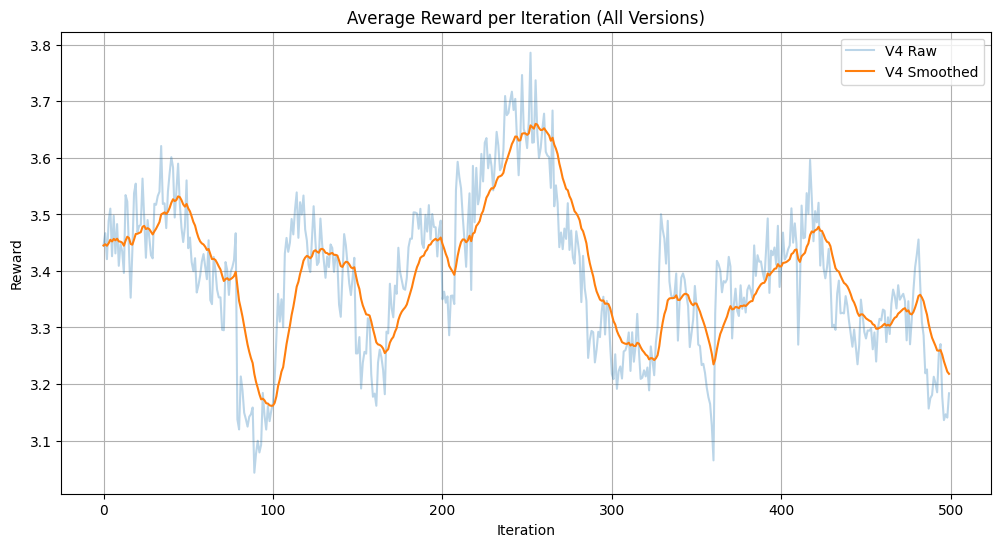

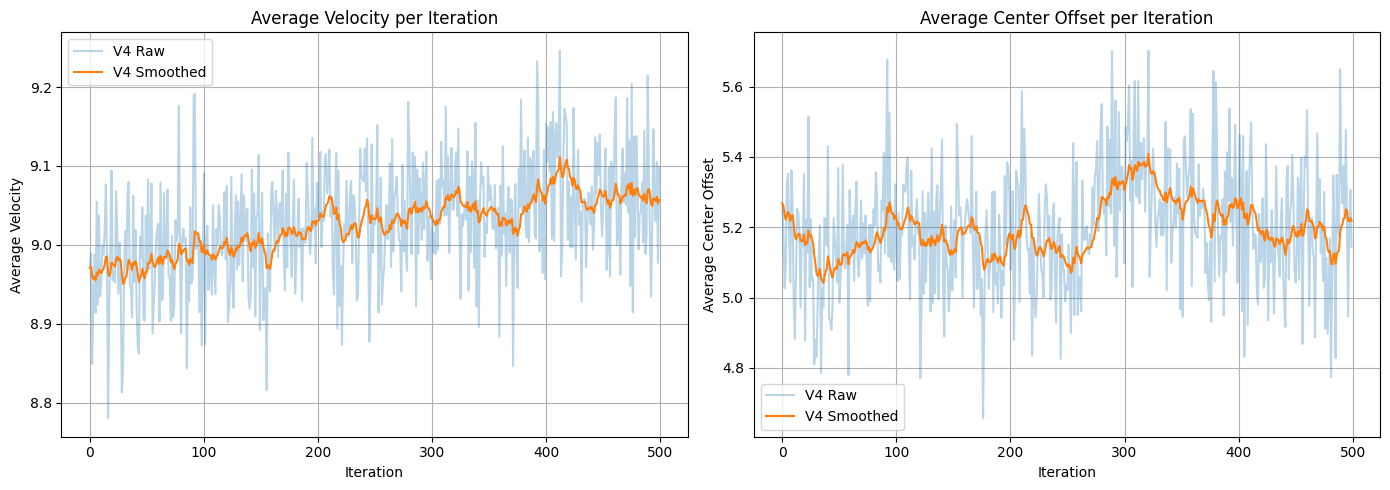

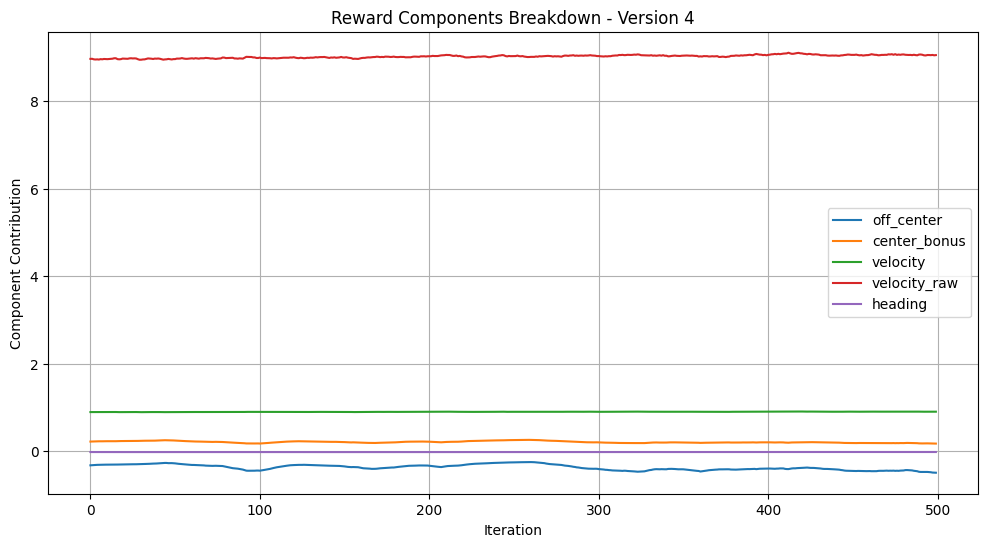

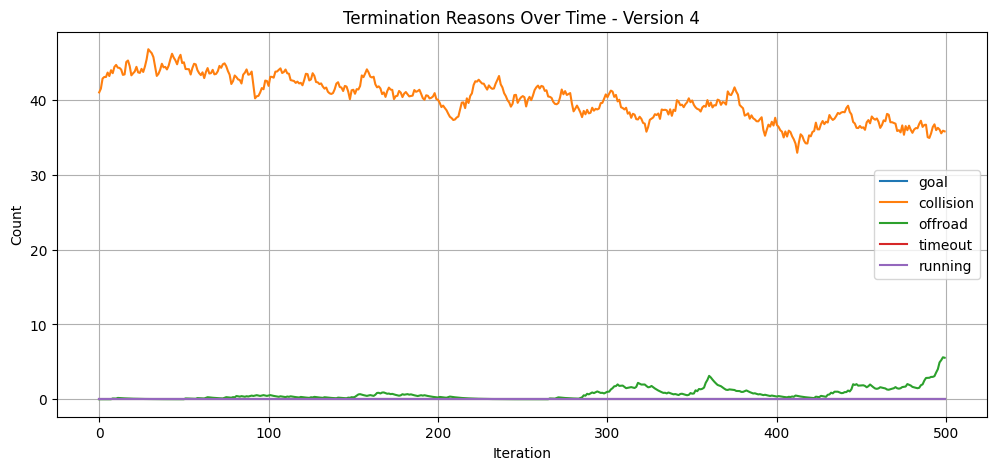

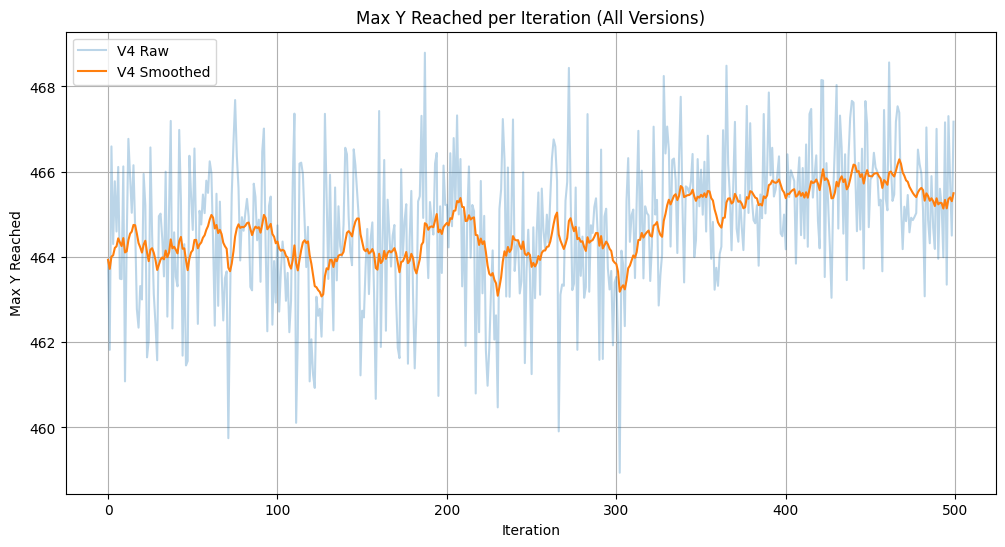

In [ ]:
# ----------------------------
# Reward plot for each version
# ----------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for version, rewards in reward_logs.items():
    plt.plot(rewards, label=f"V{version} Raw", alpha=0.3)
    plt.plot(smooth_curve(rewards), label=f"V{version} Smoothed")
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Average Reward per Iteration (All Versions)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Average velocity & offset plots
# ----------------------------
plt.figure(figsize=(14, 5))

# Velocity
plt.subplot(1, 2, 1)
for version, vels in avg_velocities.items():
    plt.plot(vels, label=f"V{version} Raw", alpha=0.3)
    plt.plot(smooth_curve(vels), label=f"V{version} Smoothed")
plt.xlabel("Iteration")
plt.ylabel("Average Velocity")
plt.title("Average Velocity per Iteration")
plt.legend()
plt.grid(True)

# Center Offset
plt.subplot(1, 2, 2)
for version, offsets in center_offsets.items():
    plt.plot(offsets, label=f"V{version} Raw", alpha=0.3)
    plt.plot(smooth_curve(offsets), label=f"V{version} Smoothed")
plt.xlabel("Iteration")
plt.ylabel("Average Center Offset")
plt.title("Average Center Offset per Iteration")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ----------------------------
# Reward components plot
# ----------------------------
for version, components in reward_components_logs.items():
    plt.figure(figsize=(12, 6))
    for key, vals in components.items():
        plt.plot(smooth_curve(vals), label=f"{key}")
    plt.title(f"Reward Components Breakdown - Version {version}")
    plt.xlabel("Iteration")
    plt.ylabel("Component Contribution")
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# Termination reasons
# ----------------------------
for version, reasons in reason_logs.items():
    reasons_by_iter = defaultdict(list)
    for counts in reasons:
        for reason in ["goal", "collision", "offroad", "timeout", "running"]:
            reasons_by_iter[reason].append(counts.get(reason, 0))
    plt.figure(figsize=(12, 5))
    for reason, counts in reasons_by_iter.items():
        plt.plot(smooth_curve(counts), label=reason)
    plt.title(f"Termination Reasons Over Time - Version {version}")
    plt.xlabel("Iteration")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# Max Y Reached plot
# ----------------------------
plt.figure(figsize=(12, 6))
for version, y_vals in y_reached_logs.items():
    plt.plot(y_vals, label=f"V{version} Raw", alpha=0.3)
    plt.plot(smooth_curve(y_vals), label=f"V{version} Smoothed")
plt.xlabel("Iteration")
plt.ylabel("Max Y Reached")
plt.title("Max Y Reached per Iteration (All Versions)")
plt.legend()
plt.grid(True)
plt.show()


Episode finished after 500 steps.
Termination reason: timeout
Total reward: 1514.10
Final Y position: 469.88


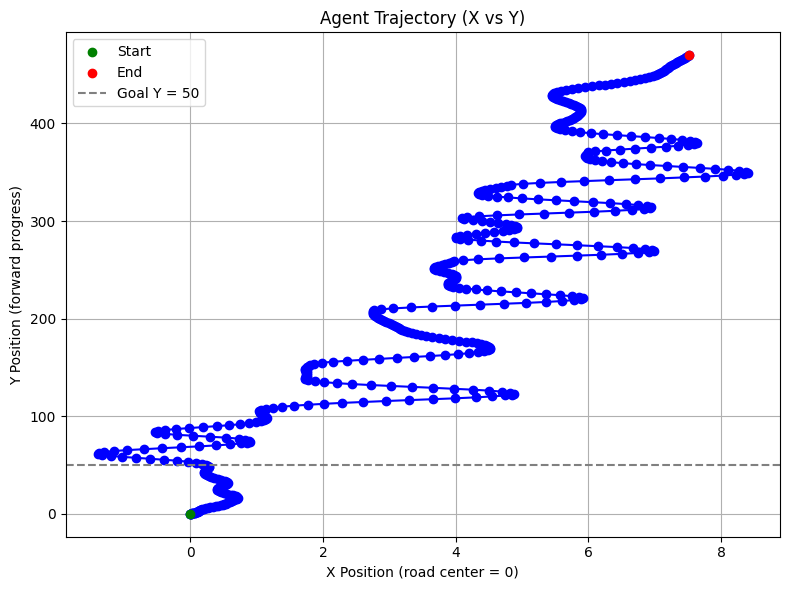

([np.float32(0.00035194642),
  np.float32(0.0016246228),
  np.float32(0.004211706),
  np.float32(0.008356202),
  np.float32(0.014164869),
  np.float32(0.021655712),
  np.float32(0.0307839),
  np.float32(0.041304573),
  np.float32(0.052849725),
  np.float32(0.06497209),
  np.float32(0.07715301),
  np.float32(0.088884726),
  np.float32(0.099720106),
  np.float32(0.1093206),
  np.float32(0.11777669),
  np.float32(0.12543833),
  np.float32(0.13300912),
  np.float32(0.14145857),
  np.float32(0.15191585),
  np.float32(0.16534643),
  np.float32(0.18286514),
  np.float32(0.20511845),
  np.float32(0.23245777),
  np.float32(0.26506528),
  np.float32(0.30244735),
  np.float32(0.3428773),
  np.float32(0.38401762),
  np.float32(0.42326805),
  np.float32(0.45868295),
  np.float32(0.48890692),
  np.float32(0.5136649),
  np.float32(0.53438276),
  np.float32(0.5535005),
  np.float32(0.57322735),
  np.float32(0.5956473),
  np.float32(0.6224361),
  np.float32(0.65226233),
  np.float32(0.6806133),
  np.fl

In [ ]:
import matplotlib.pyplot as plt

def evaluate_agent(env, policy_net, device, render=False):
    state, _ = env.reset()
    total_reward = 0
    step = 0

    x_traj = []
    y_traj = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            mean, _ = policy_net(state_tensor)
        action = mean.squeeze(0).cpu().numpy()
        action = np.clip(action, env.action_space.low, env.action_space.high)

        next_state, reward, terminated, truncated, info = env.step(action)

        total_reward += reward
        x_traj.append(env.x)
        y_traj.append(env.y)

        if render:
            env.render()

        if terminated or truncated:
            print(f"Episode finished after {step+1} steps.")
            print(f"Termination reason: {info.get('reason', 'unknown')}")
            print(f"Total reward: {total_reward:.2f}")
            print(f"Final Y position: {env.y:.2f}")
            break

        state = next_state
        step += 1

    # --- Render the entire path ---
    plt.figure(figsize=(8, 6))
    plt.plot(x_traj, y_traj, marker='o', linestyle='-', color='blue')
    plt.scatter(x_traj[0], y_traj[0], color='green', label='Start', zorder=5)
    plt.scatter(x_traj[-1], y_traj[-1], color='red', label='End', zorder=5)
    plt.axhline(y=50, color='gray', linestyle='--', label='Goal Y = 50')

    plt.xlabel("X Position (road center = 0)")
    plt.ylabel("Y Position (forward progress)")
    plt.title("Agent Trajectory (X vs Y)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return (x_traj, y_traj)

test_env = Environment()
evaluate_agent(test_env, policy_net, device)


# Animation

In [ ]:
def visualize_trajectory_with_env(x_traj, y_traj, heading_traj, env):
    import pygame
    import math

    WIDTH, HEIGHT = 800, 600
    SCALE = 10  # 1 env unit = 10 pixels
    ROAD_WIDTH = env.road_width  # use actual road width
    CENTER_X = WIDTH // 2
    FPS = 30

    BIKE_LENGTH = 2  # In env units
    BIKE_WIDTH = 0.5

    # --- Clean obstacles ---
    raw_obstacles = getattr(env, 'obstacles', [])
    cleaned_obstacles = []
    for obs in raw_obstacles:
        try:
            if isinstance(obs, dict):
                cleaned_obstacles.append((float(obs['x']), float(obs['y'])))
            elif hasattr(obs, '__getitem__'):
                cleaned_obstacles.append((float(obs[0]), float(obs[1])))
        except:
            continue

    # --- Pygame Setup ---
    pygame.init()
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("Agent Replay")
    clock = pygame.time.Clock()

    def to_screen(x, y, center_y):
        """Convert world (x, y) to screen coords centered on center_y."""
        return int(CENTER_X + x * SCALE), int(HEIGHT // 2 - (y - center_y) * SCALE)

    i = 0
    running = True
    while running:
        clock.tick(FPS)
        screen.fill((255, 255, 255))  # white background

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        if i >= len(x_traj):
            break

        agent_y = y_traj[i]

        # --- Draw road centered on current y ---
        pygame.draw.rect(screen, (180, 180, 180), (
            CENTER_X - (ROAD_WIDTH / 2) * SCALE,
            0,
            ROAD_WIDTH * SCALE,
            HEIGHT
        ))

        # --- Draw goal line (optional) ---
        goal_y = 50
        gx1, gy1 = to_screen(-ROAD_WIDTH / 2, goal_y, agent_y)
        gx2, gy2 = to_screen(ROAD_WIDTH / 2, goal_y, agent_y)
        pygame.draw.line(screen, (0, 255, 0), (gx1, gy1), (gx2, gy2), 2)

        # --- Draw obstacles near current y ---
        for ox, oy in cleaned_obstacles:
            if abs(oy - agent_y) < (HEIGHT / SCALE / 2):  # visible range
                px, py = to_screen(ox, oy, agent_y)
                pygame.draw.circle(screen, (255, 0, 0), (px, py), int(env.obstacle_radius * SCALE))

        # --- Draw bike ---
        x, y, angle = x_traj[i], y_traj[i], heading_traj[i]
        front = (x + BIKE_LENGTH * 0.5 * math.cos(angle), y + BIKE_LENGTH * 0.5 * math.sin(angle))
        rear_left = (x - BIKE_LENGTH * 0.5 * math.cos(angle) + BIKE_WIDTH * math.sin(angle),
                     y - BIKE_LENGTH * 0.5 * math.sin(angle) - BIKE_WIDTH * math.cos(angle))
        rear_right = (x - BIKE_LENGTH * 0.5 * math.cos(angle) - BIKE_WIDTH * math.sin(angle),
                      y - BIKE_LENGTH * 0.5 * math.sin(angle) + BIKE_WIDTH * math.cos(angle))

        pygame.draw.polygon(screen, (0, 0, 255), [to_screen(*pt, agent_y) for pt in [front, rear_left, rear_right]])

        pygame.display.flip()
        i += 1

    pygame.quit()


In [ ]:
test_env = Environment(reward_version=5)
x_traj, y_traj, heading_traj = [], [], []

state, _ = test_env.reset()
while True:
    x_traj.append(test_env.x)
    y_traj.append(test_env.y)
    heading_traj.append(test_env.heading)

    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        mean, _ = policy_net(state_tensor)
    action = mean.squeeze(0).cpu().numpy()
    action = np.clip(action, test_env.action_space.low, test_env.action_space.high)

    next_state, reward, terminated, truncated, info = test_env.step(action)
    if terminated or truncated:
        break
    state = next_state

visualize_trajectory_with_env(x_traj, y_traj, heading_traj, test_env)
print("Obstacles in env:", test_env.obstacles)
print("Obstacle radius:", test_env.obstacle_radius)
print("Final Y in test run:", test_env.y)


Obstacles in env: [{'x': 6.643046734085583, 'y': 111.93162322199946}, {'x': 5.288337271006352, 'y': 378.8129523509562}, {'x': 4.710334510166549, 'y': 257.17014148589243}, {'x': 0.7751679430297198, 'y': 97.0312786125588}, {'x': -2.2264761068288923, 'y': 347.58637042100355}, {'x': 5.253518208182882, 'y': 309.9421217906558}, {'x': 1.5368825778748167, 'y': 257.8021089258873}, {'x': 4.25854331281289, 'y': 154.4920143218644}, {'x': -2.200114514984441, 'y': 383.1505231687306}, {'x': 1.665987144252627, 'y': 302.47426456750003}]
Obstacle radius: 1.0
Final Y in test run: 256.84903
